### Modeling with MLOps

In [1]:
# Importing Pandas an Numpy Libraries to use on manipulating our Data
import pandas as pd
import numpy as np
import seaborn as sns
import dvc.api
import pickle
from sklearn import preprocessing

import sys
sys.path.append("../scripts")

from modeling_pipeline import (
    run_train_pipeline, 
    get_pipeline,
    dvc_get_data)
from clean_data import DataCleaner
import os
import mlflow
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')
#import packages for machine learning operation
import scipy.stats as scs
import random
import math
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.tree import DecisionTreeClassifier 
from sklearn import metrics
from sklearn.model_selection import KFold
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image  
from sklearn import tree
import scipy.stats as stat
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingClassifier

#import modules from script
from decision_tree import handler
from decision_tree import DecisionTreesModel
from XGboost import boost
from regression import Logistic
from helper import Helper
from RandomForest import RandomForest

from app_logger import App_Logger

In [3]:
cleaner= DataCleaner()
data_name="dset.csv"

In [4]:
# read df 
path = f'../data/{data_name}'
repo = 'https://github.com/TenAcademy/A_B-Hypothesis-Testing.git'
rev = 'v-0'
data_url = dvc.api.get_url(path=path, repo=None, rev=rev)
df = pd.read_csv(data_url)
df.head()

,auction_id,experiment,date,hour,device_make,platform_os,browser,yes,no
0,0008ef63-77a7-448b-bd1e-075f42c55e39,exposed,2020-07-10,8,Generic Smartphone,6,Chrome Mobile,0,0
1,000eabc5-17ce-4137-8efe-44734d914446,exposed,2020-07-07,10,Generic Smartphone,6,Chrome Mobile,0,0
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0,1
3,00187412-2932-4542-a8ef-3633901c98d9,control,2020-07-03,15,Samsung SM-A705FN,6,Facebook,0,0
4,001a7785-d3fe-4e11-a344-c8735acacc2c,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0,0


In [5]:
# df = pd.read_csv(f'../data/{data_name}')
cleaned_df=cleaner.drop_unresponsive(df)
control_df=cleaned_df[cleaned_df['experiment']=='control']
exposed_df=cleaned_df[cleaned_df['experiment']=='exposed']

combined_df=cleaned_df.drop(columns=['no'])
combined_df.rename(columns={'yes':'response'},inplace=True)
combined_df

,auction_id,experiment,date,hour,device_make,platform_os,browser,response
2,0016d14a-ae18-4a02-a204-6ba53b52f2ed,exposed,2020-07-05,2,E5823,6,Chrome Mobile WebView,0
16,008aafdf-deef-4482-8fec-d98e3da054da,exposed,2020-07-04,16,Generic Smartphone,6,Chrome Mobile,1
20,00a1384a-5118-4d1b-925b-6cdada50318d,exposed,2020-07-06,8,Generic Smartphone,6,Chrome Mobile,0
23,00b6fadb-10bd-49e3-a778-290da82f7a8d,control,2020-07-08,4,Samsung SM-A202F,6,Facebook,1
27,00ebf4a8-060f-4b99-93ac-c62724399483,control,2020-07-03,15,Generic Smartphone,6,Chrome Mobile,0
...,...,...,...,...,...,...,...,...
8059,ffa08ff9-a132-4051-aef5-01a9c79367bc,exposed,2020-07-05,21,Generic Smartphone,6,Chrome Mobile,1
8063,ffb176df-ecd2-45d3-b05f-05b173a093a7,exposed,2020-07-04,1,Generic Smartphone,6,Chrome Mobile,1
8064,ffb79718-6f25-4896-b6b3-e58b80a6e147,control,2020-07-09,7,Generic Smartphone,6,Chrome Mobile,0
8069,ffca1153-c182-4f32-9e90-2a6008417497,control,2020-07-10,16,Generic Smartphone,6,Chrome Mobile,0


### split data to browser and platform_os

In [6]:
def feature_data(df):
    browser_df=df.loc[:,df.columns!='platform_os']
    platform_df=df.loc[:,df.columns!='browser']

    return browser_df,platform_df

In [7]:
# def save_encoded_df(encoded_df):
#     browser_df,platform_df=feature_data(encoded_df)
#     browser_df.to_csv('../data/browser.csv',index=False)
#     platform_df.to_csv('../data/platform.csv',index=False)

Encoding categorical variables(label encoding)

In [8]:
def encode_labels(combined_df):
    date_encoder = preprocessing.LabelEncoder()
    device_encoder = preprocessing.LabelEncoder()
    browser_encoder = preprocessing.LabelEncoder()
    experiment_encoder = preprocessing.LabelEncoder()
    response_encoder = preprocessing.LabelEncoder()
    
    combined_df['date'] = date_encoder.fit_transform(combined_df['date'])
    combined_df['device_make'] = device_encoder.fit_transform(combined_df['device_make'])
    combined_df['browser'] = browser_encoder.fit_transform(combined_df['browser'])
    combined_df['experiment'] = experiment_encoder.fit_transform(combined_df['experiment'])
    combined_df['browser'] = response_encoder.fit_transform(combined_df['browser'])
    combined_df['response'] = response_encoder.fit_transform(combined_df['response'])


    
    return combined_df

In [9]:
# encoded_df = encode_labels(combined_df)
# save_encoded_df(encoded_df)

In [10]:
encoded_df = encode_labels(combined_df)
browser_df,platform_df=feature_data(encoded_df)

In [11]:
# uncomment this to first save the data
# browser_df.to_csv(f'../data/{data_name}',index=False)


In [12]:
# uncomment this to first sacve the data
# platform_df.to_csv(f'../data/{data_name}',index=False)


In [13]:
# versioning browser 
path = f'../data/{data_name}'
repo = 'https://github.com/TenAcademy/A_B-Hypothesis-Testing.git'
rev = 'browser-v1'
data_url = dvc.api.get_url(path=path, repo=None, rev=rev)
collected_browser_data = pd.read_csv(data_url)
collected_browser_data.head()

,auction_id,experiment,date,hour,device_make,browser,response
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,2,4,2,0
1,008aafdf-deef-4482-8fec-d98e3da054da,1,1,16,13,1,1
2,00a1384a-5118-4d1b-925b-6cdada50318d,1,3,8,13,1,0
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,0,5,4,43,4,1
4,00ebf4a8-060f-4b99-93ac-c62724399483,0,0,15,13,1,0


In [14]:
# versioning browser 
path = f'../data/{data_name}'
repo = 'https://github.com/TenAcademy/A_B-Hypothesis-Testing.git'
rev = 'platform-v1'
data_url = dvc.api.get_url(path=path, repo=None, rev=rev)
collected_platform_data = pd.read_csv(data_url)
collected_platform_data.head()

,auction_id,experiment,date,hour,device_make,platform_os,response
0,0016d14a-ae18-4a02-a204-6ba53b52f2ed,1,2,2,4,6,0
1,008aafdf-deef-4482-8fec-d98e3da054da,1,1,16,13,6,1
2,00a1384a-5118-4d1b-925b-6cdada50318d,1,3,8,13,6,0
3,00b6fadb-10bd-49e3-a778-290da82f7a8d,0,5,4,43,6,1
4,00ebf4a8-060f-4b99-93ac-c62724399483,0,0,15,13,6,0


In [15]:
def read_model(self, file_name):
    with open(f"../models/{file_name}.pkl", "rb") as f:
        self.logger.info(f"Model loaded from {file_name}.pkl")
        return pickle.load(f)

def write_model(self, file_name,model):
    with open(f"../models/{file_name}.pkl", "wb") as f:
        self.logger.info(f"Model dumped to {file_name}.pkl")
        pickle.dump(model, f)

In [16]:
browser_df=collected_browser_data.drop(columns="auction_id")
browser_df

,experiment,date,hour,device_make,browser,response
0,1,2,2,4,2,0
1,1,1,16,13,1,1
2,1,3,8,13,1,0
3,0,5,4,43,4,1
4,0,0,15,13,1,0
...,...,...,...,...,...,...
1238,1,2,21,13,1,1
1239,1,1,1,13,1,1
1240,0,6,7,13,1,0
1241,0,7,16,13,1,0


In [17]:
platform_df=collected_platform_data.drop(columns="auction_id")
platform_df

,experiment,date,hour,device_make,platform_os,response
0,1,2,2,4,6,0
1,1,1,16,13,6,1
2,1,3,8,13,6,0
3,0,5,4,43,6,1
4,0,0,15,13,6,0
...,...,...,...,...,...,...
1238,1,2,21,13,6,1
1239,1,1,1,13,6,1
1240,0,6,7,13,6,0
1241,0,7,16,13,6,0


In [18]:
# x and y for each split

X_browser = browser_df.iloc[:,:-1]
y_browser = browser_df.iloc[:,-1:]

X_platform = platform_df.iloc[:,:-1]
y_platform = platform_df.iloc[:,-1:]

### Logistic Regression

In [19]:

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_browser, y_browser, test_size=test_size, random_state=42)

In [20]:
Log = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = Log.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.545
step 0: Validation Loss of LogesticRegression is: 0.675

step 1: Validation Accuracy of LogesticRegression is: 0.527
step 1: Validation Loss of LogesticRegression is: 0.688

step 2: Validation Accuracy of LogesticRegression is: 0.554
step 2: Validation Loss of LogesticRegression is: 0.668

step 3: Validation Accuracy of LogesticRegression is: 0.543
step 3: Validation Loss of LogesticRegression is: 0.676

step 4: Validation Accuracy of LogesticRegression is: 0.574
step 4: Validation Loss of LogesticRegression is: 0.653



step 1: Test Accuracy of LogesticRegression is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.89      0.54      0.67       107
           1       0.18      0.61      0.28        18

    accuracy                           0.55       125
   macro avg       0.54      0.58      0.48       125
weighted avg       0.79      0.55      0.62       125



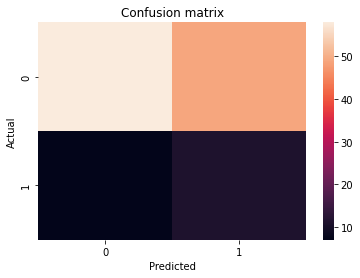

In [21]:
test_acc, test_loss, report, matrix  = Log.test()

In [22]:
p_values_df = Log.get_p_values()
p_values_df

,features,p_values
0,experiment,0.321315
1,date,0.449766
2,hour,0.003776
3,device_make,0.230609
4,browser,0.408101


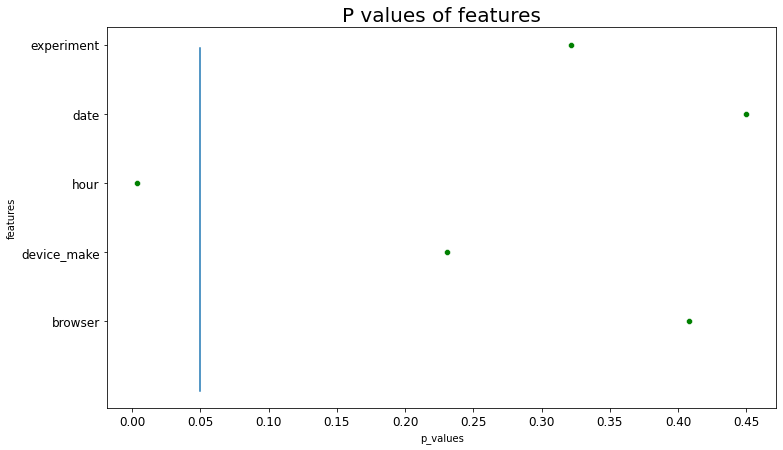

In [23]:
p_value_fig = Log.plot_pvalues(p_values_df)

In [24]:
# for platform data

test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_platform, y_platform, test_size=test_size, random_state=42)

In [25]:
Log = Logistic(X_train, X_test,  y_train, y_test)

folds = 5
clf2, loss_arr_2, acc_arr_2 = Log.train(folds)

step 0: Validation Accuracy of LogesticRegression is: 0.518
step 0: Validation Loss of LogesticRegression is: 0.694

step 1: Validation Accuracy of LogesticRegression is: 0.500
step 1: Validation Loss of LogesticRegression is: 0.707

step 2: Validation Accuracy of LogesticRegression is: 0.558
step 2: Validation Loss of LogesticRegression is: 0.665

step 3: Validation Accuracy of LogesticRegression is: 0.534
step 3: Validation Loss of LogesticRegression is: 0.683

step 4: Validation Accuracy of LogesticRegression is: 0.552
step 4: Validation Loss of LogesticRegression is: 0.670



step 1: Test Accuracy of LogesticRegression is: 0.528
Test Metrics
              precision    recall  f1-score   support

           0       0.91      0.53      0.67       112
           1       0.12      0.54      0.19        13

    accuracy                           0.53       125
   macro avg       0.51      0.53      0.43       125
weighted avg       0.83      0.53      0.62       125



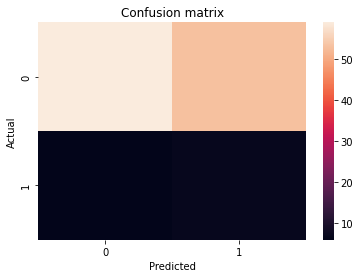

In [26]:
test_acc2, test_loss2, report2, matrix2  = Log.test()

In [27]:
p_values_df = Log.get_p_values()
p_values_df

,features,p_values
0,experiment,3.422842e-01
1,date,4.482927e-01
2,hour,3.440592e-02
3,device_make,1.236280e-01
4,platform_os,7.708564e-77


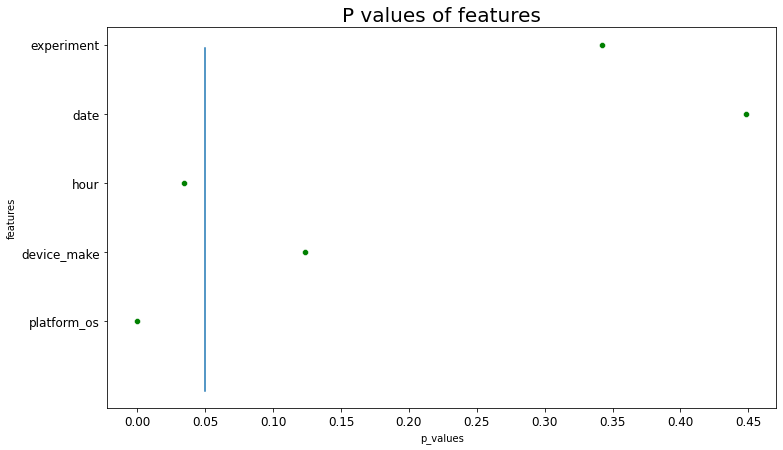

In [28]:
p_value_fig = Log.plot_pvalues(p_values_df)

### XGboost

In [29]:
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_browser, y_browser, test_size=test_size, random_state=42)

In [30]:

bst = boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = bst.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.562
step 0: Validation Loss of GradientBoostingClassifier is: 0.661

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.522
step 1: Validation Loss of GradientBoostingClassifier is: 0.691

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.545
step 2: Validation Loss of GradientBoostingClassifier is: 0.675

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.547
step 3: Validation Loss of GradientBoostingClassifier is: 0.673

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.525
step 4: Validation Loss of GradientBoostingClassifier is: 0.689



step 1: Test Accuracy of GradientBoostingClassifier is: 0.584
Test Metrics
              precision    recall  f1-score   support

           0       0.78      0.57      0.66        89
           1       0.37      0.61      0.46        36

    accuracy                           0.58       125
   macro avg       0.58      0.59      0.56       125
weighted avg       0.66      0.58      0.60       125

Loss on test data is: 0.645



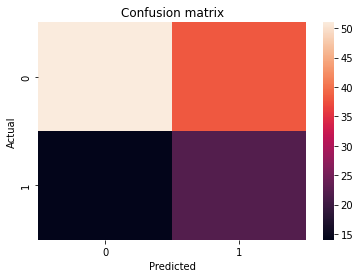

In [31]:
test_acc, loss, report, confusion_matrix = bst.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [32]:
bst.get_feature_importance()

,feature,feature_importances
0,experiment,0.081594
1,date,0.115372
2,hour,0.205221
3,device_make,0.508882
4,browser,0.088931


In [33]:


test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_platform, y_platform, test_size=test_size, random_state=42)

In [34]:
bst= boost(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = bst.train(folds)

step 0: Validation Accuracy of GradientBoostingClassifier is: 0.554
step 0: Validation Loss of GradientBoostingClassifier is: 0.668

step 1: Validation Accuracy of GradientBoostingClassifier is: 0.513
step 1: Validation Loss of GradientBoostingClassifier is: 0.698

step 2: Validation Accuracy of GradientBoostingClassifier is: 0.536
step 2: Validation Loss of GradientBoostingClassifier is: 0.681

step 3: Validation Accuracy of GradientBoostingClassifier is: 0.525
step 3: Validation Loss of GradientBoostingClassifier is: 0.689

step 4: Validation Accuracy of GradientBoostingClassifier is: 0.529
step 4: Validation Loss of GradientBoostingClassifier is: 0.686



step 1: Test Accuracy of GradientBoostingClassifier is: 0.552
Test Metrics
              precision    recall  f1-score   support

           0       0.74      0.55      0.63        87
           1       0.35      0.55      0.43        38

    accuracy                           0.55       125
   macro avg       0.54      0.55      0.53       125
weighted avg       0.62      0.55      0.57       125

Loss on test data is: 0.669



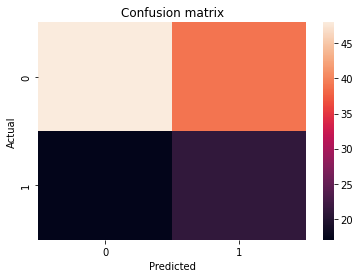

In [35]:
test_acc, loss, report, confusion_matrix = bst.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [36]:
bst.get_feature_importance()

,feature,feature_importances
0,experiment,0.063963
1,date,0.167641
2,hour,0.259592
3,device_make,0.508805
4,platform_os,0.000000


### RandomForest

In [37]:
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_browser, y_browser, test_size=test_size, random_state=42)

In [38]:
rf= RandomForest(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = rf.train(folds)

step 0: Validation Accuracy of RandomForestClassifier is: 0.522
step 0: Validation Loss of RandomForestClassifier is: 0.691

step 1: Validation Accuracy of RandomForestClassifier is: 0.549
step 1: Validation Loss of RandomForestClassifier is: 0.671

step 2: Validation Accuracy of RandomForestClassifier is: 0.545
step 2: Validation Loss of RandomForestClassifier is: 0.675

step 3: Validation Accuracy of RandomForestClassifier is: 0.525
step 3: Validation Loss of RandomForestClassifier is: 0.689

step 4: Validation Accuracy of RandomForestClassifier is: 0.619
step 4: Validation Loss of RandomForestClassifier is: 0.617



step 1: Test Accuracy of RandomForestClassifier is: 0.488
Test Metrics
              precision    recall  f1-score   support

           0       0.62      0.51      0.56        79
           1       0.35      0.46      0.40        46

    accuracy                           0.49       125
   macro avg       0.48      0.48      0.48       125
weighted avg       0.52      0.49      0.50       125

Loss on test data is: 0.716



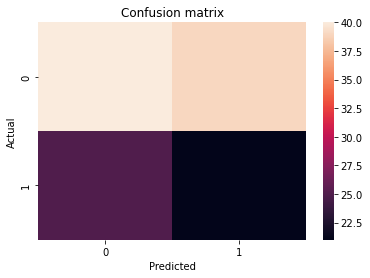

In [39]:
test_acc, loss, report, confusion_matrix = rf.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [40]:
rf.get_feature_importance()

,feature,feature_importances
0,experiment,0.051245
1,date,0.199009
2,hour,0.386802
3,device_make,0.278926
4,browser,0.084018


In [41]:
test_size = 0.1

X_train, X_test, y_train, y_test = train_test_split(X_platform, y_platform, test_size=test_size, random_state=42)

In [42]:
rf= RandomForest(X_train, X_test,  y_train, y_test)

folds = 5
clf3, acc_arr, loss_arr = rf.train(folds)

step 0: Validation Accuracy of RandomForestClassifier is: 0.540
step 0: Validation Loss of RandomForestClassifier is: 0.678

step 1: Validation Accuracy of RandomForestClassifier is: 0.513
step 1: Validation Loss of RandomForestClassifier is: 0.698

step 2: Validation Accuracy of RandomForestClassifier is: 0.536
step 2: Validation Loss of RandomForestClassifier is: 0.681

step 3: Validation Accuracy of RandomForestClassifier is: 0.480
step 3: Validation Loss of RandomForestClassifier is: 0.721

step 4: Validation Accuracy of RandomForestClassifier is: 0.565
step 4: Validation Loss of RandomForestClassifier is: 0.660



step 1: Test Accuracy of RandomForestClassifier is: 0.496
Test Metrics
              precision    recall  f1-score   support

           0       0.65      0.51      0.57        82
           1       0.33      0.47      0.39        43

    accuracy                           0.50       125
   macro avg       0.49      0.49      0.48       125
weighted avg       0.54      0.50      0.51       125

Loss on test data is: 0.710



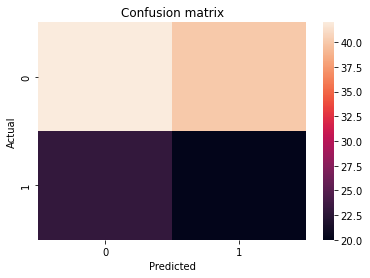

In [43]:
test_acc, loss, report, confusion_matrix = rf.test()
print(f"Loss on test data is: {loss:.3f}")
print()

In [44]:
rf.get_feature_importance()

,feature,feature_importances
0,experiment,0.037470
1,date,0.183026
2,hour,0.413761
3,device_make,0.361035
4,platform_os,0.004708
